In [130]:
import os
import cv2
import numpy as np
import collections
import pandas as pd
from extract_features import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn import svm, grid_search
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

%matplotlib inline
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## [skimage.feature.hog](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog)
## [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
## [train_and_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
## [np.nonzero( )](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html)

### General Formula of number of windows:
windows_x = 1 + (image_width - window_width)/(window_width * overlap_proportion)

windows_y = 1 + (image_height - window_height)/(window_height * overlap_proportion)

total_windows = windows_x * windows_y

# Data preprocessing

## Read  part of GTI dataset and KITTI dataset

In [94]:
car_path = './datasets/vehicles'
non_car_path = './datasets/non-vehicles'

cars = os.listdir(car_path)
non_cars = os.listdir(non_car_path)
cars = cars[1:]
non_cars = non_cars[1:]

### Create image path

In [95]:
car_list = []
ncar_list = []

for car, ncar in zip(cars, non_cars):
    car_class = os.path.join(car_path, car)
    ncar_class = os.path.join(non_car_path, ncar)
    
    for car_img, ncar_img in zip(os.listdir(car_class)[1:], os.listdir(ncar_class)[1:]):
        car_list.append(os.path.join(car_class, car_img))
        ncar_list.append(os.path.join(ncar_class, ncar_img))
print("There are {} cars images and {} non-car images".format(len(car_list), len(ncar_list)))

# Generate data 
imgs_path = np.hstack((car_list, ncar_list))
targets = np.hstack((np.ones((len(car_list) * 2,), dtype=float), np.zeros((len(ncar_list) * 2,), dtype=float)))

There are 1743 cars images and 1743 non-car images


### Extract features with normal images and flipped images

In [221]:
img_features = []
flipp = True

for path in imgs_path:
    # Extract image features
    image = mpimg.imread(path)
    img_features.append(extract_single_img_features(image, color_space='LUV', spatial_size=(16, 16),
                                                    hist_bins=32, hist_range=(0,256), orient=9, pix_per_cell=16,
                                                    cell_per_block=2, hog_channel='ALL', spatial_feature=True,
                                                    hist_feature=True, hog_feature=True))
    # Extract flipped image features
    if flipp:
        flipped_image = np.flip(image, axis=1)
        img_features.append(extract_single_img_features(flipped_image, color_space='LUV', spatial_size=(16, 16),
                                                    hist_bins=32, hist_range=(0,256), orient=9, pix_per_cell=16,
                                                    cell_per_block=2, hog_channel='ALL', spatial_feature=True,
                                                    hist_feature=True, hog_feature=True))
img_features = np.array(img_features)
print("The size of extracted feature vector is {}".format(img_features.shape[1]))
print("The number of feature vector is {}".format(img_features.shape[0]))

The size of extracted feature vector is 1324
The number of feature vector is 6972


### Split to train and test sets

In [222]:
# Pick a random number from 0 to 100
ran_state = np.random.randint(0, 100)
# Split up data into randomized training and test sets
shuff_img_features, shuff_targets = shuffle(img_features, targets)
X_train, X_test, Y_train, Y_test = train_test_split(shuff_img_features, shuff_targets, test_size=0.2, random_state=ran_state)

### Apply the scaler to both X_train and X_test
If you only extract one kind of features, you don't need to scale them

In [223]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
# save scaler
joblib.dump(X_scaler, './SVC/X_scaler.pkl') 

## Search for the SVM's best choice of parameters

In [64]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, Y_train)

print("The best choice of parameter: {}".format(clf.best_params_))

The best choice of parameter: {'C': 10, 'kernel': 'rbf'}


In [224]:
svc = svm.SVC(C=10, kernel='rbf')
svc.fit(X_train, Y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [225]:
print('Test Accuracy of SVC = ', svc.score(X_test, Y_test))
# save model
joblib.dump(svc, './SVC/svc.pkl') 

Test Accuracy of SVC =  0.994265232975


# Search for cars from test_images

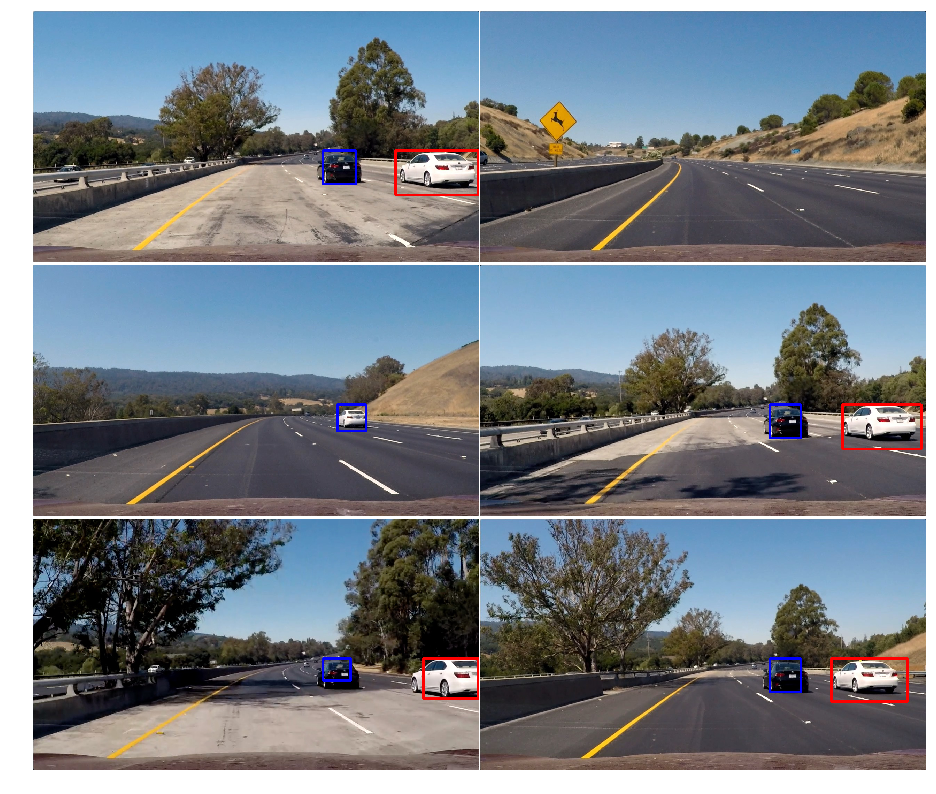

In [165]:
# img = mpimg.imread('./test_images/test6.jpg')
imgs = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
    
ystart = 400
ystop = 600
svc = joblib.load('./SVC/svc.pkl') 
X_scaler = joblib.load('./SVC/X_scaler.pkl') 

for ii, img_path in enumerate(imgs):
    img = mpimg.imread(img_path)
    bbox_list = []
    # Set multiple scales
    for scale in [0.8, 1.0, 1.3, 1.5, 1.8, 2.0]:
        window_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv='RGB2LUV', orient=9, pix_per_cell=16, 
                                                   cell_per_block=2, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64)
        if len(window_list) != 0:
            bbox_list.append(window_list)

    # Get bbox_list
    if len(bbox_list) != 0:
        bbox_list = np.array(bbox_list)
        bbox_list = np.concatenate(bbox_list)

        # Add heat
        heat = np.zeros_like(img[:,:,0])
        heat = add_heat(heat, bbox_list)
        # plt.imshow(heat)

        # Add threshold
        thresholded_heatmap = apply_threshold(heat, threshold=3)
        # plt.imshow(thresholded_heatmap)

        # Labeled heatmaps
        labels = label(thresholded_heatmap)

        # Draw boxes
        draw_img = draw_labeled_bboxes(img, labels)

    else:
        draw_img = np.copy(img)

    axs[ii].imshow(draw_img)
    axs[ii].axis('off')
    
    mpimg.imsave('./output_images/detected_test_image_{}.jpg'.format(ii+1), draw_img)

In [161]:
a = np.ones([64, 64])
de = collections.deque(maxlen=5)
for ii in range(3):
    de.append(a)
sum(de)//len(de)

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

# Detect Vehicles from videos

In [233]:
def detect_heatmap(img, svc, X_scaler, ystart, ystop):
    
    bbox_list = []
    # Set multiple scales
    for scale in [0.8, 1.0, 1.3, 1.5, 1.8, 2.0]:
#     for scale in [0.5, 0.7, 0.9, 1.1, 1.4, 1.7, 1.9, 2.1]:
        window_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv='RGB2LUV', orient=9, pix_per_cell=16, 
                                cell_per_block=2, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                                spatial_feature=False, hist_feature=True, hog_feature=True)
        if len(window_list) != 0:
            bbox_list.append(window_list)

    # Get bbox_list
    if len(bbox_list) != 0:
        bbox_list = np.array(bbox_list)
        bbox_list = np.concatenate(bbox_list)

        # Add heat
        heat = np.zeros_like(img[:,:,0])
        heat = add_heat(heat, bbox_list)
    else:
        heat = np.zeros_like(img[:,:,0])
    
    return heat

In [234]:
def detect_vehicles_from_video(img):
    
    heat = detect_heatmap(img, svc, X_scaler, y_start, y_stop)

    # add detected heat area of every frame to deque
    heatmaps.append(heat)
            
    averaged_heat = sum(heatmaps)//len(heatmaps)
    
    if len(heatmaps) < 10:
        averaged_heat = averaged_heat * 0.8
        
    # Add threshold
    thresholded_heatmap = apply_threshold(averaged_heat, threshold=thresh_hold)

    # Labeled heatmaps
    labels = label(thresholded_heatmap)

    # Draw boxes
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img

# Test on videos

In [237]:
# !mkdir test_videos_output

# Test on test video with small size
video_output = './test_videos_output/output_test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Creat deque to save detected results over several frames
heatmaps = collections.deque(maxlen=10)
# Set parameters
svc = joblib.load('./SVC/svc.pkl') 
X_scaler = joblib.load('./SVC/X_scaler.pkl') 
thresh_hold = 4
y_start = 400
y_stop = 600

project_video = VideoFileClip("./test_video.mp4")
processed_video = project_video.fl_image(detect_vehicles_from_video) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/output_test_video.mp4
[MoviePy] Writing video ./test_videos_output/output_test_video.mp4


 97%|█████████▋| 38/39 [01:51<00:03,  3.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/output_test_video.mp4 

CPU times: user 1min 46s, sys: 3.94 s, total: 1min 50s
Wall time: 1min 53s


In [238]:
# !mkdir test_videos_output

# Test on test video with small size
video_output = './test_videos_output/output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Creat deque to save detected results over several frames
heatmaps = collections.deque(maxlen=10)
# Set parameters
# svc = joblib.load('./SVC/svc.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 
thresh_hold = 5
y_start = 400
y_stop = 600

project_video = VideoFileClip("./project_video.mp4")
processed_video = project_video.fl_image(detect_vehicles_from_video) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/output_project_video.mp4
[MoviePy] Writing video ./test_videos_output/output_project_video.mp4


100%|█████████▉| 1260/1261 [1:00:14<00:02,  2.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/output_project_video.mp4 

CPU times: user 57min 44s, sys: 1min 54s, total: 59min 39s
Wall time: 1h 15s
